In [1]:
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
intents = json.loads(open('dialogbot.json').read())


In [6]:
intents

{'intents': [{'tag': ['variabel', 'mendeklarasikan', 'variabel php'],
   'patterns': ['cara mendeklarasikan variabel di php?', 'variabel php'],
   'responses': ['Di php, variabel dapat dideklarasikan dengan $nama_variabel. Contoh: $nama = "John";'],
   'context_set': ''},
  {'tag': ['crud', 'script crud', 'create read delete'],
   'patterns': ['buatkan crud dong', 'script crud', 'crud'],
   'responses': ['Tentu akan kubuatkan, buat dahulu file config.php: <?php\n/**\n * using mysqli_connect for database connection\n */\n\n$databaseHost = \'localhost\';\n$databaseName = \'crud_db\';\n$databaseUsername = \'root\';\n$databasePassword = \'\';\n\n$mysqli = mysqli_connect($databaseHost, $databaseUsername, $databasePassword, $databaseName);\n\n?> Lalu buat file index.php, masukan kode : <?php\n// Create database connection using config file\ninclude_once("config.php");\n\n// Fetch all users data from database\n$result = mysqli_query($mysqli, "SELECT * FROM users ORDER BY id DESC");\n?>\n\n<ht

In [14]:
intents = json.loads(open('dialogbot.json').read())

inputs = []
tags = []
responses = {}
classes = []
documents = []
ignore_words = ['?', '!', '.', ',', '<', '>', '-', ':', ';']
words = []

for intent in intents['intents']:
    # Konversi intent['tag'] menjadi tuple agar dapat dihash
    tag_key = tuple(intent['tag']) if isinstance(intent['tag'], list) else intent['tag']

    responses[tag_key] = intent['responses']
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, tag_key))
        inputs.append(pattern)  # Isi 'inputs' dengan pattern
        tags.append(tag_key)  # Isi 'tags' dengan tag_key

        if tag_key not in classes:
            classes.append(tag_key)

df = pd.DataFrame({"patterns": inputs, "tag": tags})

In [15]:
df

,patterns,tag
0,cara mendeklarasikan variabel di php?,"(variabel, mendeklarasikan, variabel php)"
1,variabel php,"(variabel, mendeklarasikan, variabel php)"
2,buatkan crud dong,"(crud, script crud, create read delete)"
3,script crud,"(crud, script crud, create read delete)"
4,crud,"(crud, script crud, create read delete)"
...,...,...
94,Terima Kasih,"(berakhir, penutup, akhiran)"
95,thanks bro,"(berakhir, penutup, akhiran)"
96,makasih bot,"(berakhir, penutup, akhiran)"
97,good bye,"(berakhir, penutup, akhiran)"


In [16]:
df["patterns"] = df["patterns"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df["patterns"] = df["patterns"].apply(lambda wrd: ''.join(wrd))

In [17]:
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(df["patterns"])
train = tokenizer.texts_to_sequences(df["patterns"])

In [18]:
x_train = pad_sequences(train)

In [20]:
df['tag_str'] = df['tag'].apply(lambda x: ' '.join(map(str, x)))

le = LabelEncoder()
y_train = le.fit_transform(df["tag_str"])

In [21]:
df = df.drop(columns=['tag_str'])

In [22]:
input_shape = x_train.shape[1]
print(input_shape)

11


In [23]:
unique_words = len(tokenizer.word_index)
output_length = le.classes_.shape[0]
print("unique words: ", unique_words)
print("output length: ", output_length)

unique words:  120
output length:  25


In [24]:
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

25 classes [('berakhir', 'penutup', 'akhiran'), ('bertanya', 'question', 'nanya'), ('crud', 'script crud', 'create read delete'), ('datatable', 'datatabel', 'datatable di html'), ('delete', 'delete di php', 'menghapus data'), ('edit', 'edit diphp', 'script edit'), ('error', 'kesalahan', 'penulisan'), ('form', 'form pada php', 'penulisan form'), ('gambar', 'gambar pada html', 'html gambar'), ('html', 'html sederhana', 'script html'), ('komentar', 'menambahkan komentar', 'komentar pada html'), ('link', 'link html', 'tautan'), ('menyapa', 'sapa', 'pengenalan'), ('method get dan post', 'get dan post', 'bedanya post dan get'), ('pengertian html', 'arti html', 'html adalah'), ('pengertian php', 'php', 'arti php'), ('pertanyaan kabar', 'kabar', 'kondisi'), ('pertanyaan nama', 'nama', 'nama saya'), ('php sederhana', 'script php', 'penulisan php'), ('sapaan malam', 'night', 'malammm'), ('sapaan pagi', 'pagi', 'pagiii'), ('sapaan siang', 'siang', 'sianggg'), ('sapaan sore', 'sore', 'soreee'), ('

In [25]:
vocalbulary = len(tokenizer.word_index)
print("number of unique words : ", vocalbulary)

output_length = le.classes_.shape[0]
print("output lenghth", output_length)

number of unique words :  120
output lenghth 25


In [26]:
from nltk.util import flatten
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense
from tensorflow.keras.models import Model
# Assuming you have defined input_range and output_length elsewhere in your code

i = Input(shape=(input_shape,))
x = Embedding(vocalbulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)
# Kompilasi model

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [27]:
trains = model.fit(x_train, y_train, epochs=800, validation_data=(x_train, y_train))

Epoch 1/800


4/4 [==============================] - 5s 293ms/step - loss: 3.2168 - accuracy: 0.0101 - val_loss: 3.2132 - val_accuracy: 0.1313
Epoch 2/800
4/4 [==============================] - 0s 29ms/step - loss: 3.2127 - accuracy: 0.1414 - val_loss: 3.2101 - val_accuracy: 0.1616
Epoch 3/800
4/4 [==============================] - 0s 29ms/step - loss: 3.2096 - accuracy: 0.1616 - val_loss: 3.2071 - val_accuracy: 0.1616
Epoch 4/800
4/4 [==============================] - 0s 29ms/step - loss: 3.2066 - accuracy: 0.1616 - val_loss: 3.2042 - val_accuracy: 0.1414
Epoch 5/800
4/4 [==============================] - 0s 29ms/step - loss: 3.2037 - accuracy: 0.1313 - val_loss: 3.2016 - val_accuracy: 0.1313
Epoch 6/800
4/4 [==============================] - 0s 27ms/step - loss: 3.2010 - accuracy: 0.1212 - val_loss: 3.1989 - val_accuracy: 0.1212
Epoch 7/800
4/4 [==============================] - 0s 25ms/step - loss: 3.1984 - accuracy: 0.1111 - val_loss: 3.1961 - val_accuracy: 0.1111
Epoch 8/800
4/4 [

Text(0.5, 1.0, 'loss')

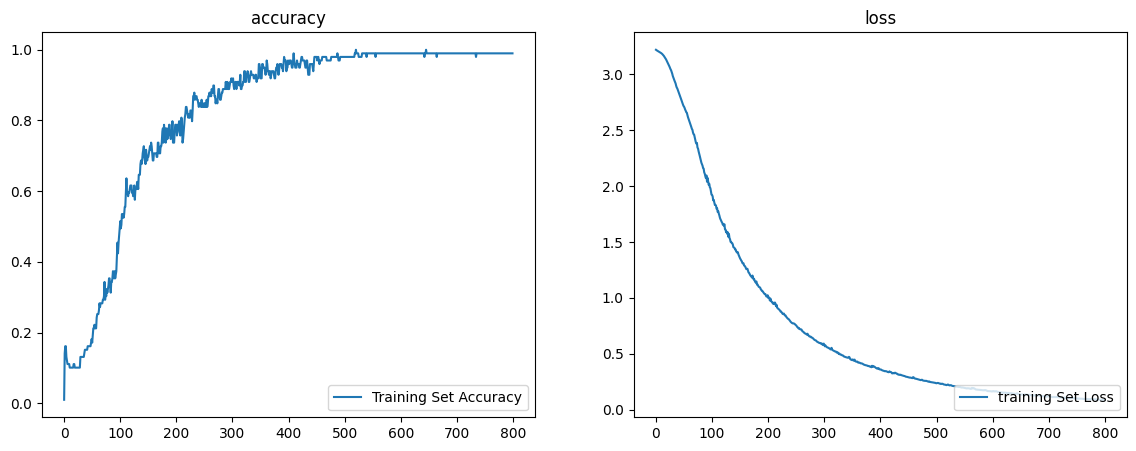

In [28]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(trains.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(trains.history['loss'],label='training Set Loss')
plt.legend(loc='lower right')
plt.title('loss')

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Mendapatkan nilai kelas prediksi dari model
y_preds = model.predict(x_train).argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_train, y_preds)
print("Test Accuracy: {:.2%}".format(accuracy))

# Mencetak laporan klasifikasi
report = classification_report(y_train, y_preds, target_names=[str(cls) for cls in classes])
print("\nClassification Report:\n", report)

# Mencetak matriks kebingungan
matrix = confusion_matrix(y_train, y_preds)
print("\nConfusion Matrix:\n", matrix)


4/4 [==============================] - 0s 4ms/step
Test Accuracy: 98.99%

Classification Report:
                                                                  precision    recall  f1-score   support

                             ('berakhir', 'penutup', 'akhiran')       1.00      1.00      1.00         4
                              ('bertanya', 'question', 'nanya')       1.00      1.00      1.00         1
                  ('crud', 'script crud', 'create read delete')       1.00      1.00      1.00         3
                ('datatable', 'datatabel', 'datatable di html')       1.00      1.00      1.00         6
                  ('delete', 'delete di php', 'menghapus data')       1.00      1.00      1.00         5
                          ('edit', 'edit diphp', 'script edit')       1.00      1.00      1.00         3
                            ('error', 'kesalahan', 'penulisan')       1.00      1.00      1.00         3
                    ('form', 'form pada php', 'penulisan form

In [31]:
from sklearn.metrics import precision_score, recall_score


def score_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted,average= 'macro')
    recall = recall_score(y_test, y_predicted,average='macro')
    print("accuracy = %0.3f, precision = %0.3f, recall = %0.3f" % (accuracy, precision, recall))
score_metrics(y_train, Y_preds)

accuracy = 0.990, precision = 0.990, recall = 0.987


In [32]:
import seaborn as sns
classes = [('berakhir', 'penutup', 'akhiran'), ('bertanya', 'question', 'nanya'), ('crud', 'script crud', 'create read delete'), ('datatable', 'datatabel', 'datatable di html'), ('delete', 'delete di php', 'menghapus data'), ('edit', 'edit diphp', 'script edit'), ('error', 'kesalahan', 'penulisan'), ('form', 'form pada php', 'penulisan form'), ('gambar', 'gambar pada html', 'html gambar'), ('html', 'html sederhana', 'script html'), ('komentar', 'menambahkan komentar', 'komentar pada html'), ('link', 'link html', 'tautan'), ('menyapa', 'sapa', 'pengenalan'), ('method get dan post', 'get dan post', 'bedanya post dan get'), ('pengertian html', 'arti html', 'html adalah'), ('pengertian php', 'php', 'arti php'), ('pertanyaan kabar', 'kabar', 'kondisi'), ('pertanyaan nama', 'nama', 'nama saya'), ('php sederhana', 'script php', 'penulisan php'), ('sapaan malam', 'night', 'malammm'), ('sapaan pagi', 'pagi', 'pagiii'), ('sapaan siang', 'siang', 'sianggg'), ('sapaan sore', 'sore', 'soreee'), ('tabel', 'html table', 'membuat tabel'), ('variabel', 'mendeklarasikan', 'variabel php')]
def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

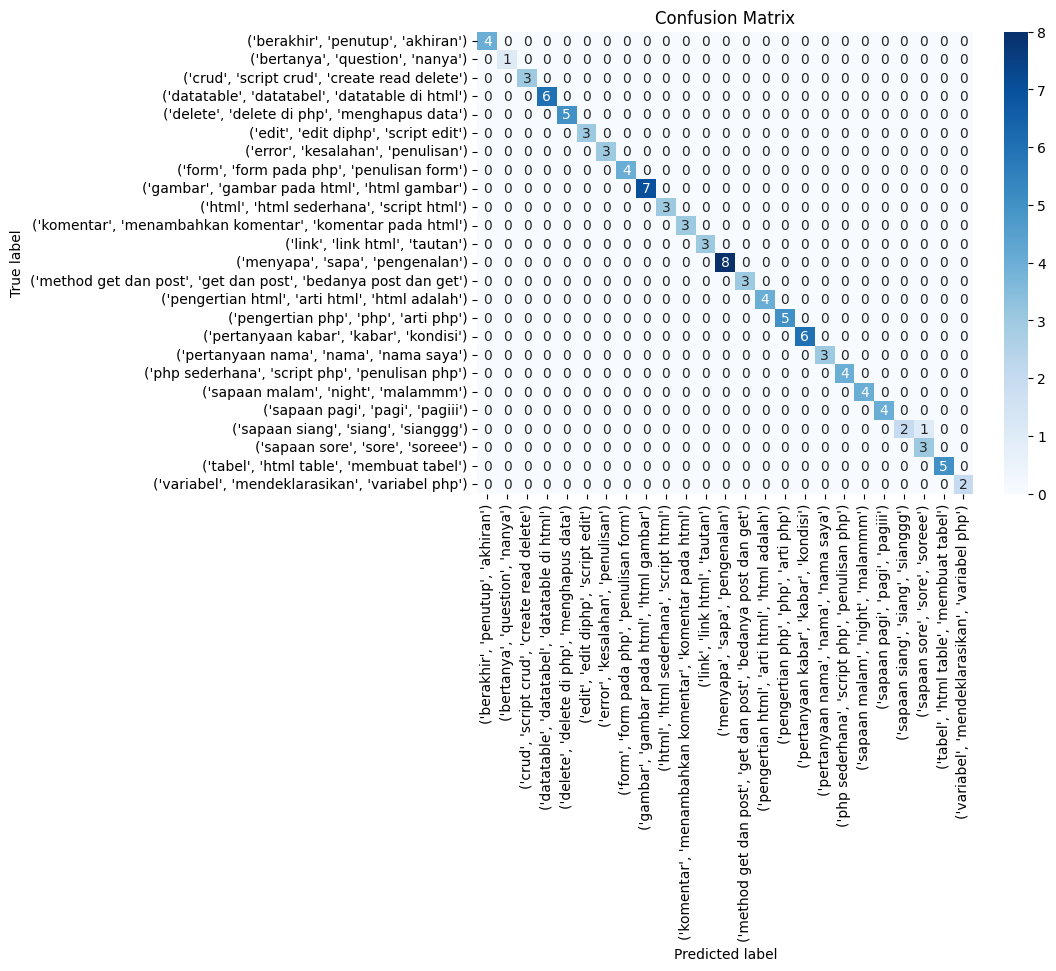

In [33]:
plot_confusion_matrix(y_train, Y_preds)

In [34]:
import pickle


pickle.dump(words,open('paterns.pkl','wb'))
pickle.dump(classes,open('tags.pkl','wb'))
model.save('LSTMV.h5')

c:\Users\ACER\miniconda3\envs\ModelLSTM\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import string

while True:
    textList = []
    user_input = input("Kamu: ")

    # Normalisasi tanda baca
    normalized_input = ''.join([c.lower() if c not in string.punctuation else ' ' for c in user_input])

    # Memastikan ada input sebelum mengirimkannya ke model
    if normalized_input.strip():
        textList.append(normalized_input)
        
        prediction_input = tokenizer.texts_to_sequences(textList)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input], input_shape)
        
        output = model.predict(prediction_input)
        output = output.argmax()
        
        response_tag = le.inverse_transform([output])[0]

        # Pengecekan sebelum memilih jawaban acak
        if response_tag in responses:
            print("BOT: {}".format(random.choice(responses[response_tag])))

        if response_tag == 'goodbye':
            break
    else:
        print("BOT: Maaf, saya tidak dapat memahami input Anda. Mohon berikan input yang jelas.")
        print("output:", output)
print("response_tag:", response_tag)
print("random response:", random.choice(responses[response_tag]))



1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: Interrupted by user